In [6]:
!ffmpeg -y -threads 16 -framerate 1 -pattern_type glob -i '../../visualization/anim/frame_*.png' -b:v 0  -crf 40 -c:v libvpx-vp9 -pix_fmt yuva420p '../../visualization/anim/frame.webm'

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import torch
from torch import Tensor
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import yaml
from yaml import SafeLoader
from captum.attr import IntegratedGradients
import tqdm
import importlib.util
import sys

from typing import Callable

from project.utils.torch_utils import batch2device
from project.dataset import GeoDataQueue
from project.pl_models.lstm_model import LSTMPL
from project.utils.geo import stacktime, stackdims, msc_align
from project.utils.types import BatchPattern

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['font.family'] = 'monospace'

In [9]:
exp_config = './experiments/default/exp_00_2023-03-24_21-34-56/cv/best_config.yaml'
exp_model = './experiments/default/exp_00_2023-03-24_21-34-56/'

In [10]:
with open(exp_config, 'r') as f:
    config = yaml.load(f, SafeLoader)

data_config = config['data']
model_path = config['model']['class_path']
model_path, model_name = model_path.rsplit('.', 1)
model_path = model_path.replace('.', '/')
model_path += '.py'

spec = importlib.util.spec_from_file_location(model_name, model_path)
model = importlib.util.module_from_spec(spec)
sys.modules[model_name] = model
spec.loader.exec_module(model)
model = getattr(model, model_name)

In [11]:
data_config['batch_size'] = 2
data_config['return_baseline'] = True

In [12]:
geodata = GeoDataQueue(**data_config, precip_zero_baseline=True)

In [13]:
model = model.load_from_checkpoint(exp_model, map_location=torch.device('cuda:3')).to(torch.device('cuda:3'))

In [14]:
dataloader = geodata.predict_dataloader()

In [18]:
len(dataloader.dataset.chunk_coords)

93

In [8]:
batch = next(iter(dl))

In [9]:
batch = batch2device(batch, torch.device('cuda:3'))

In [ ]:
pred, _ = model(
    x=batch.f_hourly,
    x_msc=batch.t_daily_msc,
    x_ano=batch.t_daily_ano,
    time=batch.coords.dayofyear,
    s=batch.f_static)
pred = batch2device(pred, torch.device('cpu'), detach=True)

In [73]:
pred_bl, _ = model(
    x=batch.f_hourly_bl,
    x_msc=batch.t_daily_msc,
    x_ano=batch.t_daily_ano,
    time=batch.coords.dayofyear,
    s=batch.f_static)
pred_bl = batch2device(pred_bl, torch.device('cpu'), detach=True)

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20), sharex=True)

for i, ax in enumerate(axes.flatten()):
    ax.plot(batch.t_daily_ano[i, :, 0].detach().cpu(), color='k', lw=1.5, alpha=0.8, label='observed')
    ax.plot(pred.ano[i, :, 0].detach().cpu(), color='tab:red', lw=1.5, alpha=0.8, label='predicted (x)')
    ax.plot(pred_bl.ano[i, :, 0].detach().cpu(), color='tab:blue', lw=1.5, alpha=0.8, label='predicted ($x_{baseline}$)')

    if i == 0:
        ax.legend()

In [148]:
torch.cuda.empty_cache()

In [10]:
print(torch.cuda.memory_summary(device=torch.device('cuda:3')))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 3                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   14611 KB |   16599 KB |   27858 KB |   13247 KB |
|       from large pool |   14070 KB |   14070 KB |   17190 KB |    3120 KB |
|       from small pool |     541 KB |   10359 KB |   10668 KB |   10127 KB |
|---------------------------------------------------------------------------|
| Active memory         |   14611 KB |   16599 KB |   27858 KB |   13247 KB |
|       from large pool |   14070 KB |   14070 KB |   17190 KB |

In [172]:
class Attributions(object):
    def __init__(self, batch: BatchPattern, geodata: GeoDataQueue, context_size: int, start_date: str | None = None, end_date: str | None = None) -> None:

        self.batch = batch
        self.geodata = geodata

        self._arg_check(batch, context_size, start_date)

        self.start_date = self.batch.coords.window_start[0] if start_date is None else start_date
        self.context_start_date = pd.date_range(end=self.start_date, freq='D', periods=context_size)[0].strftime('%Y-%m-%d')
        self.end_date = self.batch.coords.window_end[0] if end_date is None else end_date
        self.context_size = context_size
        self.data_start_date = pd.date_range(end=self.window_end, freq='D', periods=batch.f_hourly.shape[1])[0].strftime('%Y-%m-%d')

        if pd.Timestamp(self.context_start_date) < pd.Timestamp(self.data_start_date):
            raise ValueError(
                f'`context_size={context_size}` too large for `start_date={start_date}` and infered '
                f'` data_start_date={self.data_start_date}`.'
            )

        self.start_idx = len(pd.date_range(self.data_start_date, self.start_date, freq='D')) - 1
        self.end_idx = len(pd.date_range(self.data_start_date, self.end_date, freq='D')) - 1

        self.obs, self.msc, self.attr = self.emptyXR()

    def __len__(self) -> int:
        return self.end_idx - self.start_idx + 1

    def __iter__(self):
        for i in range(self.start_idx, self.end_idx + 1):
            yield (
                batch.f_hourly[:, i - self.context_size + 1:i + 1, ...],
                batch.f_static,
                batch.f_hourly_bl[:, i - self.context_size + 1:i + 1, ...],
                batch.f_static_bl,
                i
            )

    def _arg_check(self, batch: BatchPattern, context_size: int, start_date: str) -> None:
        for el in ['window_start', 'window_end', 'num_days']:
            batch_el = getattr(self.batch.coords, el)
            if not all([e == batch_el[0] for e in batch_el]):
                raise ValueError(
                    'BatchIterator expects batch with full sequences, but found different values in on of '
                    '\'batch.coords.window_start\', \'batch.coords.window_end\', \'batch.coords.num_days\'.'
                )

        if pd.Timestamp(start_date) < pd.Timestamp(self.window_start):
            raise ValueError(
                f'`start_date={start_date}` out of batch range {self.window_start, self.window_end}'
            )
        if pd.Timestamp(start_date) > pd.Timestamp(self.window_end):
            raise ValueError(
                f'`start_date={start_date}` out of batch range {self.window_start, self.window_end}'
            )

    def emptyXR(self) -> xr.Dataset:
        obs = self.geodata.ds.sel(
            lat=xr.DataArray(self.batch.coords.lat.cpu(), dims=['sample']),
            lon=xr.DataArray(self.batch.coords.lon.cpu(), dims=['sample']),
            time=slice(self.context_start_date, self.end_date))[self.geodata.features_hourly + self.geodata.features_static]

        obs = obs.rename({'rh_cf': 'rh'}).transpose('sample', ...).load()

        msc = self.geodata.ds.sel(
            lat=xr.DataArray(self.batch.coords.lat.cpu(), dims=['sample']),
            lon=xr.DataArray(self.batch.coords.lon.cpu(), dims=['sample']),
            time=slice(self.context_start_date, self.end_date))[[f'{v}_msc' for v in self.geodata.features_hourly]]

        msc = msc.rename({v + '_msc': v for v in self.geodata.features_hourly}).rename({'rh_cf': 'rh'}).transpose('sample', ...).load()

        msc = msc_align(msc, obs)

        attr = xr.full_like(obs, np.nan)
        for var in attr.data_vars:
            if 'time' in attr[var].dims:
                attr[var] = attr[var].expand_dims(context=np.arange(-self.context_size + 1, 1)).copy()

        attr = attr.sel(time=slice(self.start_date, None)).transpose('sample', ...).load()

        return obs, msc, attr

    def assign_attrs(self, attrs: list[Tensor], time_i: int) -> None:
        for i, variable in enumerate([v for v in self.attr.data_vars if 'time' in self.attr[v].dims]):
            self.attr[variable].values[..., time_i, :] = attrs[0].detach().cpu()[..., i]

        if time_i == 0:
            for i, variable in enumerate([v for v in self.attr.data_vars if 'time' not in self.attr[v].dims]):
                self.attr[variable].values[:] = attrs[1][:, i].detach().cpu()

    def context2time(self, ds: xr.Dataset):
        return ds.assign_coords(
            context=pd.date_range(end=ds.time.item(), periods=self.context_size, freq='D')
        ).drop('time').rename({'context': 'time'})

    def __getitem__(self, idx: int) -> tuple[xr.Dataset, xr.Dataset]:
        attr_ = stacktime(self.context2time(self.attr.isel(time=idx)))
        obs_ = stacktime(self.obs).sel(time=attr_.time)
        msc_ = stacktime(self.msc).sel(time=attr_.time)

        return obs_, msc_, attr_

    def isel(self, **subset) -> tuple[xr.Dataset, xr.Dataset]:
        if 'idx' in subset:
            idx = subset.pop('idx')
            obs_, msc_, attr_ = self[idx]
        else:
            attr_ = self.attr
            obs_ = self.obs
            msc_ = self.msc

        attr_ = attr_.isel(**subset)
        obs_ = obs_.isel(**subset)
        msc_ = msc_.isel(**subset)

        return obs_, msc_, attr_
    
    def sel(self, **subset) -> tuple[xr.Dataset, xr.Dataset]:
        if 'idx' in subset:
            idx = subset.pop('idx')
            attr_, msc_, obs_ = self[idx]
        else:
            attr_ = self.attr
            obs_ = self.obs
            msc_ = self.msc

        attr_ = attr_.sel(**subset)
        obs_ = obs_.sel(**subset)
        msc_ = msc_.isel(**subset)

        return obs_, msc_, attr_

    @property
    def obs_flat(self) -> xr.Dataset:
        return stacktime(self.obs)

    @property
    def msc_flat(self) -> xr.Dataset:
        return stacktime(self.msc)

    @property
    def attr_flat(self) -> xr.Dataset:
        return stackdims(self.attr, ['context', 'hour'], 'context', False)

    @property
    def f_hourly(self) -> list[str]:
        return [v for v in self.obs.data_vars if 'time' in self.obs[v].dims]

    @property
    def f_static(self) -> list[str]:
        return [v for v in self.obs.data_vars if 'time' not in self.obs[v].dims]

    @property
    def window_start(self) -> str:
        return self.batch.coords.window_start[0]

    @property
    def window_end(self) -> str:
        return self.batch.coords.window_end[0]

In [173]:
attr = Attributions(batch=batch, geodata=geodata, context_size=365 * 5, start_date='2015-01-01', end_date='2015-12-31')

In [174]:
def model_patch(x, x_b):
    return model(x, None, None, None, x_b)[0].ano

ig = IntegratedGradients(model_patch)

In [175]:
for i, (f_hourly, f_static, f_hourly_bl, f_static_bl, time_i) in tqdm.tqdm(enumerate(attr), total=len(attr), ncols=120):
    attributions = ig.attribute(
        inputs=(f_hourly, f_static),
        baselines=(f_hourly_bl, f_static_bl),
        method='gausslegendre',
        return_convergence_delta=False,
        target=-1,
        internal_batch_size=25
    )
    break
    attr.assign_attrs(attributions, i)

  0%|                                                                                           | 0/365 [00:01<?, ?it/s]


In [176]:
attributions

(tensor([[[[-1.5976e-08,  5.9169e-11,  5.7089e-05,  0.0000e+00],
           [-1.3118e-06,  0.0000e+00,  1.6101e-04,  0.0000e+00],
           [-5.4835e-06,  0.0000e+00,  3.6891e-04,  2.4535e-06],
           ...,
           [ 2.0740e-06,  0.0000e+00, -1.0086e-05,  4.4716e-06],
           [-4.2418e-07, -0.0000e+00, -1.0552e-06,  2.6343e-06],
           [-4.7388e-07,  8.5480e-11,  1.1562e-06,  1.1170e-06]],
 
          [[ 1.8908e-07,  6.3796e-12, -4.0212e-06,  1.2082e-06],
           [-1.6826e-08,  0.0000e+00, -8.6364e-06,  8.6703e-07],
           [-2.4588e-06,  0.0000e+00, -1.4830e-05,  7.8373e-07],
           ...,
           [-1.5495e-06,  0.0000e+00, -2.8356e-06,  3.1410e-05],
           [ 2.1848e-06,  0.0000e+00,  2.3579e-07,  1.6954e-05],
           [ 1.7315e-06, -5.2212e-12,  2.0495e-07,  1.6508e-06]],
 
          [[-2.2649e-07,  1.9067e-12, -1.6795e-07, -1.8193e-09],
           [-1.6376e-07,  0.0000e+00,  9.0007e-07, -1.6651e-08],
           [-1.5103e-07,  0.0000e+00,  2.0118e-06,  

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)

#obs_, attr_ = attr.isel(idx=150, sample=0, time=slice(-1000, None))
obs_, msc_, attr_ = attr.isel(idx=150, sample=0, time=slice(-2500, None))

lim = np.abs(attr_[attr.f_hourly].to_array().quantile([0.01, 0.99])).max().item()

for v, var in enumerate(attr.f_hourly):
    ax = axes[v]

    #lim = np.abs(attr_[var].quantile([0.01, 0.99])).max().item()
    ax.plot(obs_.time, msc_[var], color='k', lw=0.8, zorder=10)
    #ax.plot(obs_.time, msc_[var], color='k', lw=1.1, zorder=11)
    ax.plot(obs_.time, obs_[var], color='tab:blue', lw=1.0, zorder=20)
    #ax.plot(obs_.time, obs_[var], color='tab:blue', lw=0.8, zorder=21)
    ymn, ymx = ax.get_ylim()
    yextra = (ymx - ymn) * 0.2
    ymn_ = ymn - yextra
    ymx_ = ymx + yextra
    im = ax.pcolorfast(
        (mpl.dates.date2num(obs_.time[0]), mpl.dates.date2num(obs_.time[-1])), (ymn_, ymn),
        attr_[var].values.reshape(1, -1), cmap='PiYG', vmin=-lim, vmax=lim, alpha=0.8)
    im = ax.pcolorfast(
        (mpl.dates.date2num(obs_.time[0]), mpl.dates.date2num(obs_.time[-1])), (ymn, ymx),
        attr_[var].values.reshape(1, -1), cmap='PiYG', vmin=-lim, vmax=lim, alpha=0.3)
    im = ax.pcolorfast(
        (mpl.dates.date2num(obs_.time[0]), mpl.dates.date2num(obs_.time[-1])), (ymx, ymx_),
        attr_[var].values.reshape(1, -1), cmap='PiYG', vmin=-lim, vmax=lim, alpha=0.8)

    ax.set_ylabel(var.upper())

    # for day in np.unique(obs_.time.dt.date)[1:]:
        # ax.axvline(mpl.dates.date2num(day), color='k', lw=0.4, ls='--')

    # for year in pd.date_range(attr_.time[0].item(), attr_.time[-1].item(), freq='YS'):
    #     ax.axvline(mpl.dates.date2num(year), color='k', lw=0.4, ls='--')

fig.colorbar(im, ax=axes.ravel().tolist(), label='Impact on FVC')

fig.align_ylabels(axes)

fig.suptitle(f'Ref date: {obs_.time[-1].dt.strftime("%Y-%m-%d").item()}')
fig.autofmt_xdate(rotation=90, ha='center')

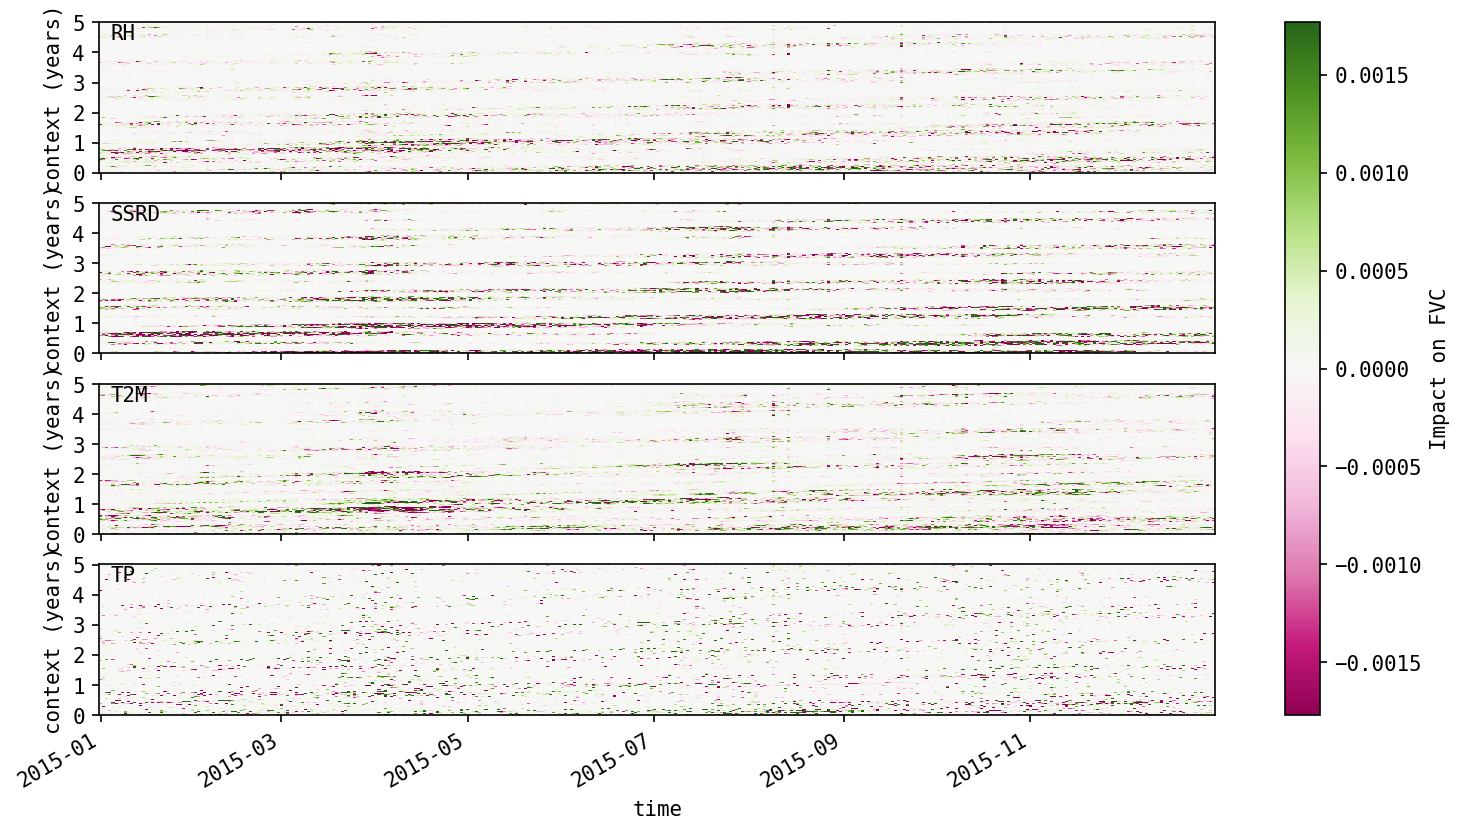

In [49]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(12, 6))

lim = np.abs(attr.attr[attr.f_hourly].to_array().quantile([0.01, 0.99])).max().item()

for i, var in enumerate(attr.f_hourly):
    ax = axes.flatten()[i]
    im = attr.attr_flat[var].isel(sample=0).T.plot(cmap='PiYG', ax=ax, add_colorbar=False, vmin=-lim, vmax=lim)
    ax.set_title('')
    if i < 3:
        ax.set_xlabel('')
    ax.invert_yaxis()
    ax.text(0.01, 0.99, var.upper(), ha='left', va='top', transform=ax.transAxes)
    ytick_pos = np.arange(0, -len(attr.attr_flat.context), -364 * 24)
    ytick_labels = np.arange(len(ytick_pos))
    ax.set_yticks(ytick_pos, labels=ytick_labels)
    ax.set_ylabel('context (years)')

fig.colorbar(im, ax=axes.ravel().tolist(), label='Impact on FVC')

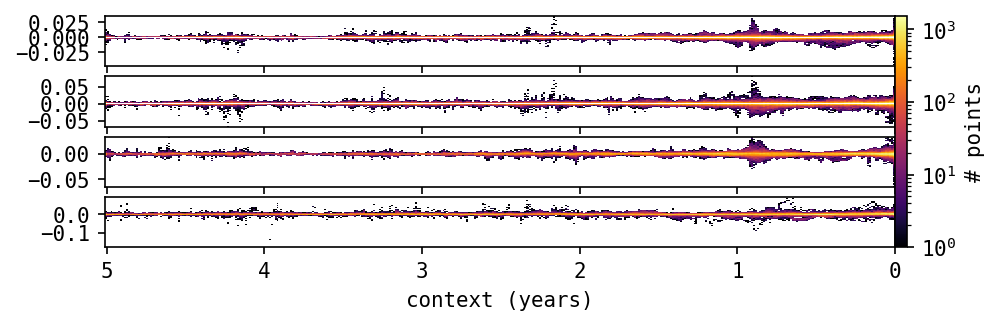

In [87]:
fig, axes = plt.subplots(4, 1, figsize=(8, 2), sharex=True)

threshold = 0.001

for i, var in enumerate(attr.f_hourly):
    ax = axes[i]
    x = attr.attr_flat.context.expand_dims(time=attr.attr.time).values
    y = attr.attr_flat[var].isel(sample=0).values


    mask = np.abs(y) > threshold
    x = x[mask]
    y = y[mask]

    h, xedges, yedges = np.histogram2d(
        x,
        y,
        bins=[400, 100]
    )

    pcm = ax.pcolormesh(
        xedges, yedges, h.T, cmap='inferno', rasterized=True, norm=mpl.colors.LogNorm()
    )

    xtick_pos = np.arange(0, -len(attr.attr_flat.context), -364 * 24)
    xtick_labels = np.arange(len(xtick_pos))
    ax.set_xticks(xtick_pos, labels=xtick_labels)
    ax.set_xlabel('context (years)')

fig.colorbar(pcm, ax=axes, label="# points", pad=0)

In [38]:
class Attributions(object):
    def __init__(
            self,
            model_call: Callable,
            init_batch: BatchPattern,
            geodata: GeoDataQueue,
            context_size: int,
            start_date: str,
            end_date: str,
            zarr_dir: str) -> None:

        self.model_call = model_call
        self.batch = init_batch
        self.geodata = geodata

        self._arg_check(batch, context_size, start_date)

        self.start_date = start_date
        self.context_start_date = pd.date_range(end=self.start_date, freq='D', periods=context_size)[0].strftime('%Y-%m-%d')
        self.end_date = end_date
        self.context_size = context_size
        self.data_start_date = pd.date_range(end=self.window_end, freq='D', periods=batch.f_hourly.shape[1])[0].strftime('%Y-%m-%d')

        self.zarr_dir = zarr_dir
        self.ig = IntegratedGradients(model_patch)

        if pd.Timestamp(self.context_start_date) < pd.Timestamp(self.data_start_date):
            raise ValueError(
                f'`context_size={context_size}` too large for `start_date={start_date}` and infered '
                f'` data_start_date={self.data_start_date}`.'
            )

        self.start_idx = len(pd.date_range(self.data_start_date, self.start_date, freq='D')) - 1
        self.end_idx = len(pd.date_range(self.data_start_date, self.end_date, freq='D')) - 1

        self.emptyXR()
        self.zarr_ds = xr.open_zarr(self.zarr_dir)

    def __len__(self) -> int:
        return self.end_idx - self.start_idx + 1

    def get_attr(self, f_hourly: Tensor, f_static: Tensor, f_hourly_bl: Tensor, f_static_bl: Tensor):
        attributions = self.ig.attribute(
            inputs=(f_hourly, f_static),
            baselines=(f_hourly_bl, f_static_bl),
            method='gausslegendre',
            return_convergence_delta=False,
            target=-1
        )
        attr = [a.detach().cpu().numpy() for a in attributions]
        attributions = None
        return attr

    def iter_batch(self, batch: BatchPattern):
        for i in tqdm.tqdm(range(self.start_idx, self.end_idx + 1), leave=False, position=1, desc='IG        '):
            yield self.get_attr(
                batch.f_hourly[:, i - self.context_size + 1:i + 1, ...],
                batch.f_static,
                batch.f_hourly_bl[:, i - self.context_size + 1:i + 1, ...],
                batch.f_static_bl,
            )

    def get_batch_attr(self, batch: BatchPattern):
        attr_hourly = []
        attr_static = []

        for i, a in tqdm.tqdm(enumerate(self.iter_batch(batch)), total=len(attr), position=0, desc='Dataloader'):
            attr_hourly.append(a[0])
            attr_static.append(a[1])

        attr_hourly = np.stack(attr_hourly, axis=2)
        attr_static = np.stack(attr_static, axis=1)

        return attr_hourly, attr_static

    def _arg_check(self, batch: BatchPattern, context_size: int, start_date: str) -> None:
        for el in ['window_start', 'window_end', 'num_days']:
            batch_el = getattr(self.batch.coords, el)
            if not all([e == batch_el[0] for e in batch_el]):
                raise ValueError(
                    'BatchIterator expects batch with full sequences, but found different values in on of '
                    '\'batch.coords.window_start\', \'batch.coords.window_end\', \'batch.coords.num_days\'.'
                )

        if pd.Timestamp(start_date) < pd.Timestamp(self.window_start):
            raise ValueError(
                f'`start_date={start_date}` out of batch range {self.window_start, self.window_end}'
            )
        if pd.Timestamp(start_date) > pd.Timestamp(self.window_end):
            raise ValueError(
                f'`start_date={start_date}` out of batch range {self.window_start, self.window_end}'
            )

    def emptyXR(self) -> xr.Dataset:
        obs = self.geodata.ds.sel(
            time=slice(self.start_date, self.end_date))[self.geodata.features_hourly + self.geodata.features_static]

        attr = xr.full_like(obs, np.nan)
        for var in attr.data_vars:
            if 'time' in attr[var].dims:
                attr[var] = attr[var].expand_dims(context=np.arange(-self.context_size + 1, 1))
            else:
                attr[var] = attr[var].expand_dims(time=obs.time)

        lat_chunksize = obs.chunksizes['lat'][0]
        lon_chunksize = obs.chunksizes['lon'][0]
        attr = attr.chunk({
            'context': -1,
            'time': -1,
            'hour': -1,
            'lat': lat_chunksize,
            'lon': lon_chunksize
        })

        attr.to_zarr(self.zarr_dir, compute=False, mode='w')

    def assign_attrs(self, attrs: list[Tensor], time_i: int) -> None:
        for i, variable in enumerate([v for v in self.attr.data_vars if 'time' in self.attr[v].dims]):
            self.attr[variable].values[..., time_i, :] = attrs[0].detach().cpu()[..., i]

        if time_i == 0:
            for i, variable in enumerate([v for v in self.attr.data_vars if 'time' not in self.attr[v].dims]):
                self.attr[variable].values[:] = attrs[1][:, i].detach().cpu()

    @property
    def window_start(self) -> str:
        return self.batch.coords.window_start[0]

    @property
    def window_end(self) -> str:
        return self.batch.coords.window_end[0]

In [39]:
import multiprocessing as mp

class IGWriter(object):
    def __init__(self, zarr_file, dataloader):
        self.zarr_file = zarr_file
        self.dataloader = dataloader
        self.mask = self.dataloader.dataset.mask.load()

        self.chunks = {}
        self.chunk_bounds_lat = QueueFiller.coords2bounds(dataloader.dataset.data.mask, dim='lat', chunk_size=20)
        self.chunk_bounds_lon = QueueFiller.coords2bounds(dataloader.dataset.data.mask, dim='lon', chunk_size=20)

        self.processes: list[mp.Process] = []

    def write_attr(self, attrs_hourly, attrs_static, batch):
        for i, chunk_id in enumerate(batch.coords.chunk.cpu().numpy()):
            if chunk_id not in self.chunks:
                chunk_lat, chunk_lon = self.dataloader.dataset.chunk_coords[chunk_id]

                lat_bounds = slice(*self.chunk_bounds_lat[chunk_lat])
                lon_bounds = slice(*self.chunk_bounds_lon[chunk_lon])
                num_samples = self.mask.isel(lat=lat_bounds, lon=lon_bounds).sum().compute()

                chunk_ds = self.zarr_file.isel(lat=lat_bounds, lon=lon_bounds).load()

                self.chunks[chunk_id] = {
                    'ds': chunk_ds,
                    'num_samples': num_samples,
                    'num_saved': 0,
                    'lat_bounds': lat_bounds,
                    'lon_bounds': lon_bounds
                }

            for v, var in enumerate(self.dataloader.dataset.features_hourly):
                for i in range(attr_hourly.shape[0]):
                    self.chunks[chunk_id]['ds'][var].loc[
                        {
                            'lat': batch.coords.lat[i].cpu(),
                            'lon': batch.coords.lon[i].cpu(),
                        }
                    ] = attr_hourly[i, ..., v]

            for v, var in enumerate(self.dataloader.dataset.features_static):
                for i in range(attr_static.shape[0]):
                    self.chunks[chunk_id]['ds'][var].loc[
                        {
                            'lat': batch.coords.lat[i].cpu(),
                            'lon': batch.coords.lon[i].cpu(),
                        }
                    ] = attr_static[i, ..., v]

            self.chunks[chunk_id]['num_saved'] += 1

            if self.chunks[chunk_id]['num_saved'] == self.chunks[chunk_id]['num_samples']:
                process = mp.Process(target=self.write_chunk, args=(self.chunks[chunk_id],))
                self.processes.append(process)
                process.start()
                del self.chunks[chunk_id]

            remove_processes = []
            for process_i, process in enumerate(self.processes):
                if not process.is_alive():
                    remove_processes.append(process_i)

            if len(remove_processes) > 0:

                for process_i in reversed(remove_processes):
                    process = self.processes.pop(process_i)
                    process.terminate()
                    process.join()

    def on_predict_epoch_end() -> None:

        for chunk in self.chunks.values():
            self.write_chunk(chunk)

        self.chunks = {}

    def write_chunk(self, chunk: dict) -> None:
        chunk_ds = chunk['ds'].drop_vars(['time'])

        chunk_ds.to_zarr(self.zarr_file.encoding['source'], consolidated=True, region={
            'lat': chunk['lat_bounds'],
            'lon': chunk['lon_bounds']
        })


In [41]:
def model_patch(x, x_b):
    return model(x, None, None, None, x_b)[0].ano

batch = next(iter(dataloader))

attr = Attributions(
    model_call=model_patch,
    init_batch=batch,
    geodata=geodata,
    context_size= 100, #365 * 3,
    start_date='2015-01-01',
    end_date='2015-12-31',
    zarr_dir='test.zarr'
)

igwriter = IGWriter(attr.zarr_ds, dataloader)

In [ ]:
for i, batch in enumerate(dataloader):
    batch = batch2device(batch, torch.device('cuda:3'))
    attr_hourly, attr_static = attr.get_batch_attr(batch)
    igwriter.write_attr(attrs_hourly=attr_hourly, attrs_static=attr_static, batch=batch)

In [2]:
import xarray as xr

In [2]:
ds = xr.open_zarr('./experiments/default/exp_00_2023-03-30_16-03-29/tune/trial00/ig.zarr/')
cube = xr.open_zarr('/Net/Groups/BGI/scratch/bkraft/drought_data/cube.zarr')

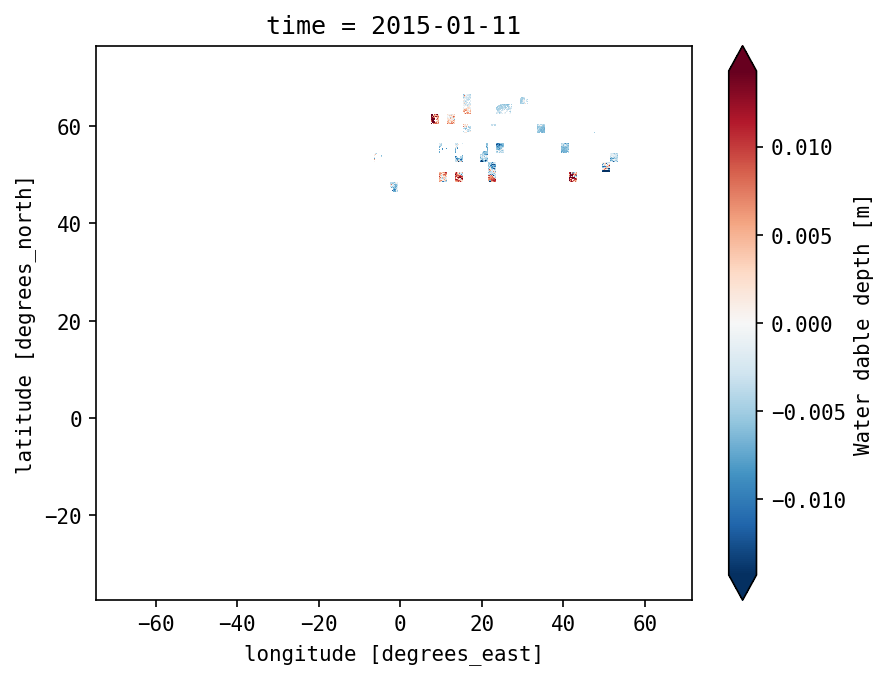

In [3]:
ds.wtd.isel(time=10).plot(robust=True)

In [89]:
ds

<xarray.Dataset>
Dimensions:             (time: 365, lat: 1140, lon: 1460, context: 10, hour: 24)
Coordinates:
  * context             (context) int64 -9 -8 -7 -6 -5 -4 -3 -2 -1 0
  * hour                (hour) int64 0 1 2 3 4 5 6 7 ... 16 17 18 19 20 21 22 23
  * lat                 (lat) float32 76.5 76.4 76.3 76.2 ... -37.2 -37.3 -37.4
  * lon                 (lon) float32 -74.5 -74.4 -74.3 -74.2 ... 71.2 71.3 71.4
  * time                (time) datetime64[ns] 2015-01-01 ... 2015-12-31
Data variables:
    canopyheight        (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>
    percent_tree_cover  (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>
    rh_cf               (context, time, hour, lat, lon) float32 dask.array<chunksize=(10, 365, 24, 20, 20), meta=np.ndarray>
    rootdepth           (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>
    sandfrac            (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>
    ssrd                (context, time, hour, lat, lon) float32 dask.array<chunksize=(10, 365, 24, 20, 20), meta=np.ndarray>
    t2m                 (context, time, hour, lat, lon) float32 dask.array<chunksize=(10, 365, 24, 20, 20), meta=np.ndarray>
    topidx              (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>
    tp                  (context, time, hour, lat, lon) float32 dask.array<chunksize=(10, 365, 24, 20, 20), meta=np.ndarray>
    wtd                 (time, lat, lon) float32 dask.array<chunksize=(365, 20, 20), meta=np.ndarray>

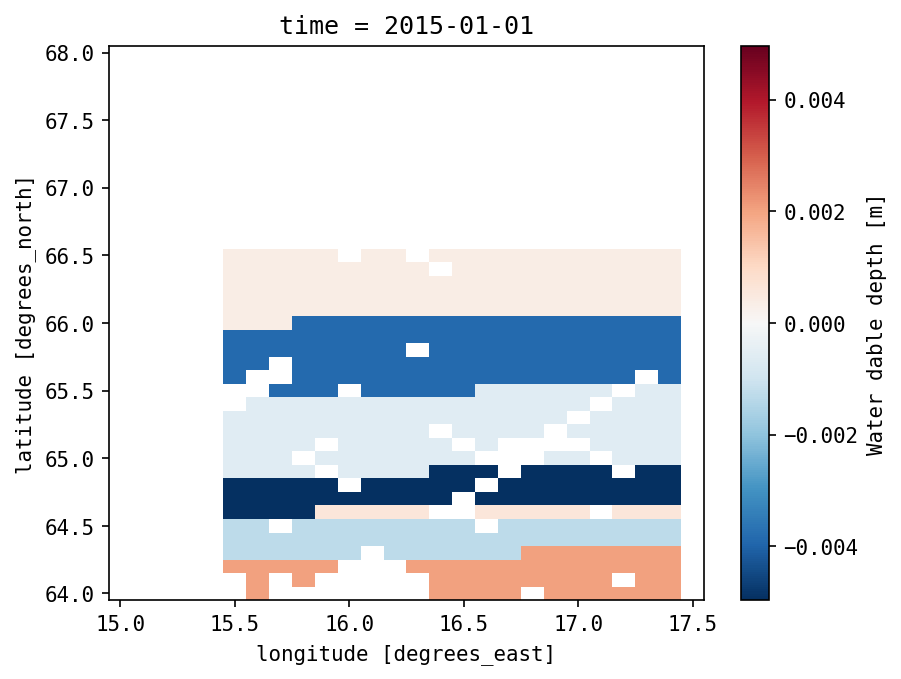

In [92]:
ds.wtd.sel(lat=slice(68, 64), lon=slice(15, 17.5)).isel(time=0).plot()

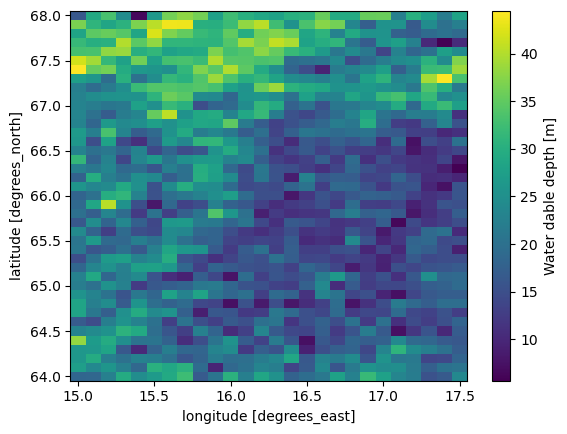

In [48]:
cube.wtd.sel(lat=slice(68, 64), lon=slice(15, 17.5)).plot()

In [58]:
cube.tp.sel(lat=66.0, lon=16.0)

<xarray.DataArray 'tp' (time: 7305, hour: 24)>
dask.array<getitem, shape=(7305, 24), dtype=float32, chunksize=(300, 24), chunktype=numpy.ndarray>
Coordinates:
  * hour     (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 14 15 16 17 18 19 20 21 22 23
    lat      float32 66.0
    lon      float32 16.0
  * time     (time) datetime64[ns] 2002-01-01 2002-01-02 ... 2021-12-31
Attributes:
    long_name:  Total precipitation
    mean:       0.12476687176274043
    std:        0.5033277055413958
    units:      m

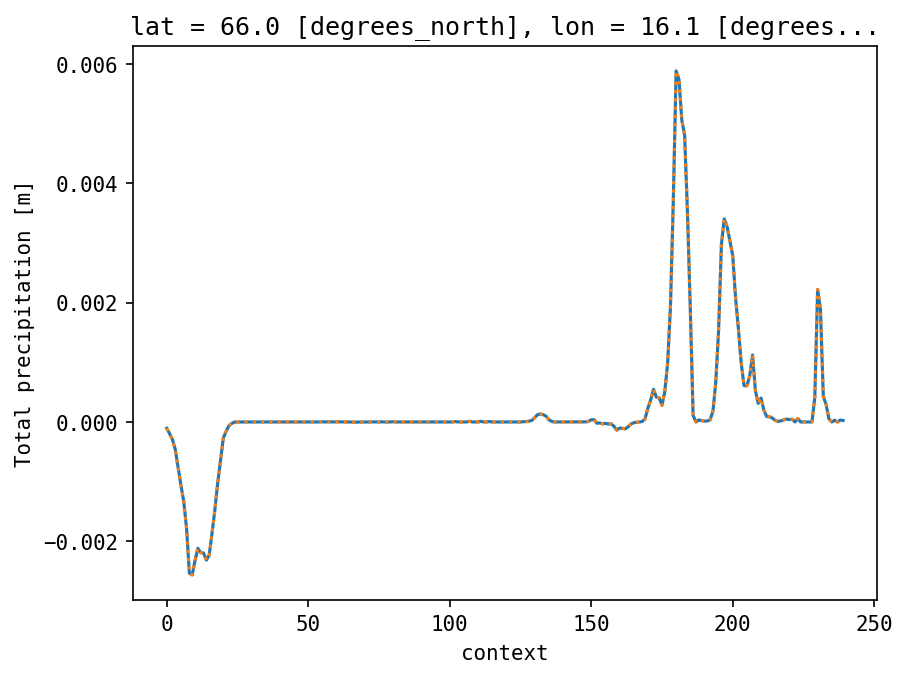

In [98]:
ds_sel = stackdims(ds.tp.sel(lat=66.0, lon=16.0).isel(time=0), ['context', 'hour'], 'context').plot()
ds_sel = stackdims(ds.tp.sel(lat=66.0, lon=16.1).isel(time=0), ['context', 'hour'], 'context').plot(ls=':')

In [85]:
ds_sel = stackdims(ds.tp.sel(lat=66.0, lon=16.0).isel(time=0), ['context', 'hour'], 'context')
ds_sel
cube_sel = stacktime(cube.tp.sel(lat=66.0, lon=16.0).sel(time=slice(None, ds_sel.time))).isel(time=slice(-len(ds_sel.context), None))
cube_sel['time'] = ds_sel['context'].values
cube_sel = cube_sel.rename({'time': 'context'})

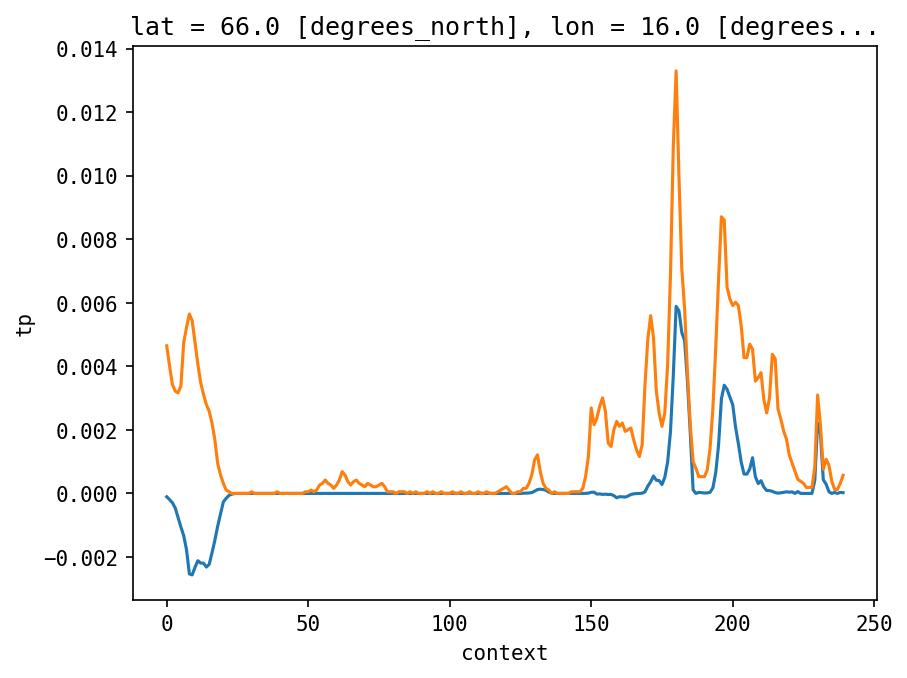

In [88]:
ds_sel.plot()
(cube_sel / 100).plot()